## 1. Get and Set Azure Credentials 

In [ ]:
!az login

In [2]:
!az ad sp create-for-rbac --sdk-auth > mycredentials.json

Retrying role assignment creation: 1/36
Retrying role assignment creation: 2/36


In [3]:
import os, json
with open('mycredentials.json') as data_file:    
    azure_session = json.load(data_file)
# delete credentials file
os.remove("mycredentials.json")

## 2. Create Azure Resource Manager Client

In [4]:
from azure.common.credentials import ServicePrincipalCredentials
from azure.mgmt.resource import ResourceManagementClient
from azure.mgmt.resource.resources.models import DeploymentMode

In [5]:
credentials = ServicePrincipalCredentials(
    client_id=azure_session["clientId"],
    secret=azure_session["clientSecret"],
    tenant=azure_session["tenantId"]
)
client = ResourceManagementClient(credentials, azure_session["subscriptionId"])

## 3. Resource Group Parameters

In [6]:
RESOURCE_GROUP_NAME = 'kustodeploymenttest' # Set resource group name here
AZURE_REGION = 'East US' # Set region here
location = ''.join(AZURE_REGION.split()).lower()

## 4. Azure Data Explorer Cluster Parameters

In [7]:
CLUSTER_NAME = 'cdacluster'
CLUSTER_NODE_SIZE = 'D13_v2'
CLUSTER_NODE_TEIR = 'Standard'
CLUSTER_NODE_CAPACITY = 2

## 5. Set Azure Data Explorer DB Deployment Parameters

In [8]:
DB_NAME = 'cdadb'
DB_SOFT_DELETION_PERIOD = 3650
DB_HOT_CACHE_PERIOD = 31
URI = "https://{}.{}.kusto.windows.net:443".format(CLUSTER_NAME, location)
DATA_INGESTION_URI = "https://ingest-{}.{}.kusto.windows.net:443/".format(CLUSTER_NAME, location)

## 6. Define Azure Data Explorer Deployment Template

In [9]:
template = {\
    "$schema": "https://schema.management.azure.com/schemas/2015-01-01/deploymentTemplate.json#",
    "contentVersion": "1.0.0.0",
    "resources": [\
        {\
            "type": "Microsoft.Kusto/Clusters",
            "sku": {\
                "name": CLUSTER_NODE_SIZE,
                "tier": CLUSTER_NODE_TEIR,
                "capacity": CLUSTER_NODE_CAPACITY
            },
            "name": CLUSTER_NAME,
            "apiVersion": "2017-09-07-privatepreview",
            "location": AZURE_REGION,
            "properties": {\
                "trustedExternalTenants": [
                    {
                        "value": azure_session["tenantId"]
                    }
                ],                
            }
        },
        {\
            "type": "Microsoft.Kusto/Clusters/Databases",
            "name": "{}/{}".format(CLUSTER_NAME, DB_NAME),
            "apiVersion": "2017-09-07-privatepreview",
            "location": AZURE_REGION,
            "properties": {
                "softDeletePeriodInDays": DB_SOFT_DELETION_PERIOD,
                "hotCachePeriodInDays": DB_HOT_CACHE_PERIOD,
            },
            "dependsOn": [\
                "[resourceId('Microsoft.Kusto/Clusters', '{}')]".format(CLUSTER_NAME)
            ]
        }
    ]
}

In [10]:
deployment_properties = {
    'mode': DeploymentMode.incremental,
    'template': template,
}

## 7. Create Resource Group and Deploy 
Note this could take 10-15 min and is not necessary if you've run the last notebook

In [13]:
resource_group_params = {'location':location}
client.resource_groups.create_or_update('kustodeploymenttest', resource_group_params)

# https://docs.microsoft.com/en-us/python/api/azure-mgmt-resource/azure.mgmt.resource.resources.v2018_05_01.operations.deploymentsoperations?view=azure-python#create-or-update
deployment_async_operation = client.deployments.create_or_update(
    RESOURCE_GROUP_NAME,
    'azure-sample',
    deployment_properties
)
deployment_async_operation.wait()

## 8. Install Kusto Ingestion Libraries for Stream Ingestion

In [14]:
# Install Perquisite Libraries
!pip install azure-kusto-data==0.0.13
!pip install azure-kusto-ingest==0.0.13

## 9. Create Kusto Client

In [15]:
from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder
from azure.kusto.data.exceptions import KustoServiceError
from azure.kusto.data.helpers import dataframe_from_result_table
import pandas as pd
import datetime

In [16]:
KCSB_ENGINE = KustoConnectionStringBuilder.with_aad_application_key_authentication(URI,
                                                                            azure_session["clientId"],
                                                                            azure_session["clientSecret"],
                                                                            azure_session["tenantId"])

In [17]:
KUSTO_CLIENT = KustoClient(KCSB_ENGINE)

## 10. Create a Table Called Github Event to hold our data 

In [18]:
CREATE_TABLE_COMMAND = ".create table GithubEvent ( Id:int64, Type: string, Actor: dynamic, Repo: dynamic, Payload: dynamic, Public:bool, CreatedAt: datetime)"
RESPONSE = KUSTO_CLIENT.execute_mgmt(DB_NAME, CREATE_TABLE_COMMAND)
dataframe_from_result_table(RESPONSE.primary_results[0])

,TableName,Schema,DatabaseName,Folder,DocString
0,GithubEvent,"{""Name"":""GithubEvent"",""OrderedColumns"":[{""Name...",cdadb,None,None


## 11. Create ingestion Mapping from for ingesting events from EventHub

In [19]:
CREATE_MAPPING_COMMAND = """.create table GithubEvent ingestion json mapping "GitMapping" '[{"column":"Id","path":"$.id"},{"column":"Type","path":"$.type"},{"column":"Actor","path":"$.actor"},{"column":"Repo","path":"$.repo"},{"column":"Payload","path":"$.payload"},{"column":"Public","path":"$.public"},{"column":"CreatedAt","path":"$.created_at"}]'"""

RESPONSE = KUSTO_CLIENT.execute_mgmt(DB_NAME, CREATE_MAPPING_COMMAND)
dataframe_from_result_table(RESPONSE.primary_results[0])

,Name,Kind,Mapping,LastUpdatedOn,Database,Table
0,GitMapping,JSON,"[{""column"":""Id"",""path"":""$.id"",""datatype"":null,...",2019-01-19 18:45:36.824973600,cdadb,GithubEvent


## 11. Create  Event Hub using the Azure CLI to Ingest All Github Events

In [ ]:
# Create an Event Hubs namespace. Specify a name for the Event Hubs namespace.
!az eventhubs namespace create --name 'kusto-github-EHNS' --resource-group 'kustodeploymenttest' -l 'East US'

In [ ]:
# Create an event hub. Specify a name for the event hub. 
!az eventhubs eventhub create --name 'kusto-github-EH' --resource-group 'kustodeploymenttest' --namespace-name 'kusto-github-EHNS'

### Create a EH User and Key for Github Ingestion

In [ ]:
!az eventhubs eventhub authorization-rule create --eventhub-name 'kusto-github-EH'\
                                                --name 'kusto-github-EH-key'\
                                                --namespace-name 'kusto-github-EHNS'\
                                                --resource-group 'kustodeploymenttest'\
                                                --rights 'Send'

## 12. Use ARM to link the new EventHub with our Cluster

In [31]:
template = { \
    "$schema": "https://schema.management.azure.com/schemas/2015-01-01/deploymentTemplate.json#",
    "contentVersion": "1.0.0.0",
    "resources": [
        {  
            "type":"Microsoft.Kusto/clusters/databases/eventhubconnections",
            "name":"{}/{}/{}".format(CLUSTER_NAME, DB_NAME, 'github'),
            "apiVersion":"2018-09-07-preview",
            "location": AZURE_REGION,
            "properties":{  
                "consumerGroup":"$Default",                
                "eventHubResourceId":"[resourceId('Microsoft.EventHub/namespaces/eventhubs', 'kusto-github-EHNS', 'kusto-github-EH')]",
                "tableName":"GithubEvent",
                "mappingRuleName":"GitMapping",
                "dataFormat":"JSON"
            }
        }
    ]
}

deployment_properties = {
    'mode': DeploymentMode.incremental,
    'template': template,
}

# https://docs.microsoft.com/en-us/python/api/azure-mgmt-resource/azure.mgmt.resource.resources.v2018_05_01.operations.deploymentsoperations?view=azure-python#create-or-update
deployment_async_operation = client.deployments.create_or_update(
    RESOURCE_GROUP_NAME,
    'azure-sample',
    deployment_properties
)
deployment_async_operation.wait()

## 13. Use the Azure CLI to create an container instance to ingest all the github events into our EventHub 

You'll need a github developer token you can get one for free from using [these instructions](https://github.blog/2013-05-16-personal-api-tokens/).

### Get EH Key

In [ ]:
!az eventhubs eventhub authorization-rule keys list --resource-group 'kustodeploymenttest' --namespace-name 'kusto-github-EHNS' --eventhub-name 'kusto-github-EH' --name 'kusto-github-EH-key'

### Run CLI Command
To get the from github to eventhub I've created the following python ingestion scripts that run on alpine docker checkout the code [here](https://github.com/aribornstein/github2eventhub) this can be reused new projects. 

In [ ]:
!az container create -g kustodeploymenttest --name gh2eh --image abornst/gh2eh --cpu 1 --memory 1 \
--environment-variables "eh_address"="amqps://kusto-github-EHNS.servicebus.windows.net/kusto-github-EH"\
                        "eh_user"="kusto-github-EH-key" "eh_key"="primaryKey see above" \
                        "gh_token"="GitHub Token See instructions above" 

## 14. Lets start seeing how many events we've pulled from Github let's give it ~5-20min to populate

In [165]:
QUERY = "GithubEvent | count"

RESPONSE = KUSTO_CLIENT.execute_query(DB_NAME, QUERY)

dataframe_from_result_table(RESPONSE.primary_results[0])

,Count
0,472381


## 15. Now That we have our Data Let's try some interesting queries and use pandas and matplotlib to plot them.

### What are the 5 most popular Repos on Github?

In [157]:
QUERY = """let watchedRepos =  
    GithubEvent 
    | where Type == "WatchEvent"
    | extend RepoName = tostring(Repo.name)
    | summarize hint.shufflekey=RepoName WatchEvents=count() by RepoName;
let issuesRepos =  
    GithubEvent
    | where Type in ("IssueCommentEvent", "IssuesEvent")
    | extend RepoName = tostring(Repo.name)
    | summarize hint.shufflekey=RepoName IssueEvents=count() by RepoName;
watchedRepos
| join hint.shufflekey=RepoName (issuesRepos) on RepoName
| extend Popularity=(WatchEvents * 0.3) + (IssueEvents*0.7) 
| top 5 by Popularity 
| project RepoName, Popularity """

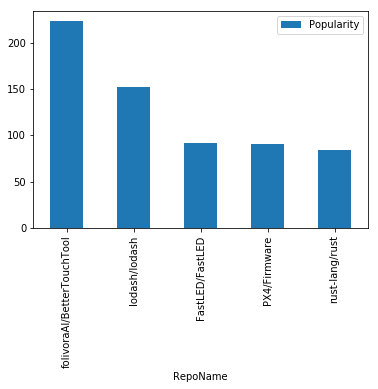

In [158]:
RESPONSE = KUSTO_CLIENT.execute_query(DB_NAME, QUERY)
dataframe_from_result_table(RESPONSE.primary_results[0]).plot.bar(x='RepoName')

# Challenge 
Use the service and [query langauge](https://docs.microsoft.com/azure/kusto/query/?WT.mc_id=code-github-abornst) to find the following and tweet your results to @pythiccoder

- What are the most popular programming langauges of the last year (by watch events)?
- What is the sentiment over time of the top 10 programming languages on Github?
- Who are the top most active users by country? 
- Who are the github users with the most contributions to the top 50 most popular repos?
